In [0]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
num_classes=2
num_epochs=10
batch_size=10
learning_rate=0.2

In [0]:
def loadTrainData(data_dir,resize=(224,224)):
  data_transforms={
      'train': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ]),
      'val': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ]),
      'test': transforms.Compose([
          transforms.RandomResizedCrop(max(resize)),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ])
      
  }
  dataset={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
          for x in ['train','test','val']}
  dataset_loader={x:torch.utils.data.DataLoader(dataset[x],
                                                batch_size=batch_size,
                                               shuffle=True)
                 for x in ['train','test','val']}
  dataset_size={x:len(dataset[x]) for x in ['train','test','val']}
  dataset_classes=dataset['train'].classes
  return dataset_loader['train'],dataset_loader['val'],dataset_loader['test']

In [0]:
data_dir="/content/drive/My Drive/Projects/Pneumonia detection/chest_xray/chest_xray/"
train_loader, val_loader,test_loader=loadTrainData(data_dir)

##Model

In [0]:
class DenseNet121(nn.Module):
  def __init__(self,out_size):
    super(DenseNet121,self).__init__()
    self.densenet121=torchvision.models.densenet121(pretrained=True)
    num_features=self.densenet121.classifier.in_features
    self.densenet121.classifier=nn.Sequential(
    nn.Linear(num_features,out_size),
    nn.Sigmoid())
  def forward(self,x):
    x=self.densenet121(x)
    return x

model=DenseNet121(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
32342954it [00:00, 94796977.63it/s]


In [0]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [0]:
total_step=len(train_loader)
for epoch in range(num_epochs):
  for i,(images,labels) in enumerate(train_loader):
    images=images.to(device)
    labels=labels.to(device)
    
    outputs=model(images)
    loss=criterion(outputs,labels)
    #print(images.size())
    bs, c, h, w = images.size() #batch_size
    input_var = torch.autograd.Variable(images.view(-1, c, h, w).cuda(), volatile=True)
    output = model(input_var)
    output_mean = output.view(bs, -1).mean(1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(i+1)%100==0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


Epoch [1/10], Step [100/522], Loss: 0.4133
Epoch [1/10], Step [200/522], Loss: 0.6133
Epoch [1/10], Step [300/522], Loss: 0.6133
Epoch [1/10], Step [400/522], Loss: 0.5133
Epoch [1/10], Step [500/522], Loss: 0.5133
Epoch [2/10], Step [100/522], Loss: 0.4133
Epoch [2/10], Step [200/522], Loss: 0.5133
Epoch [2/10], Step [300/522], Loss: 0.5133
Epoch [2/10], Step [400/522], Loss: 0.5133
Epoch [2/10], Step [500/522], Loss: 0.8133
Epoch [3/10], Step [100/522], Loss: 0.5133
Epoch [3/10], Step [200/522], Loss: 0.5133
Epoch [3/10], Step [300/522], Loss: 0.9133
Epoch [3/10], Step [400/522], Loss: 0.6133
Epoch [3/10], Step [500/522], Loss: 0.4133
Epoch [4/10], Step [100/522], Loss: 0.5133
Epoch [4/10], Step [200/522], Loss: 0.3133
Epoch [4/10], Step [300/522], Loss: 0.5133
Epoch [4/10], Step [400/522], Loss: 0.7133
Epoch [4/10], Step [500/522], Loss: 0.8133
Epoch [5/10], Step [100/522], Loss: 0.6133
Epoch [5/10], Step [200/522], Loss: 0.4133
Epoch [5/10], Step [300/522], Loss: 0.5133
Epoch [5/10

##Test


In [0]:
def get_tensor(image_bytes,resize=(224,224)):
     my_transforms = transforms.Compose([
          transforms.RandomResizedCrop(max((resize))),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
      ])
	image = Image.open(io.BytesIO(image_bytes))
return my_transforms(image).unsqueeze(0)

##Resnet


In [0]:
from torchvision import models, transforms
model_res = models.resnet18(pretrained=True)
model_res.cuda()
model_res.eval()
final_layer_res = model_res._modules.get('layer4')


In [0]:
torch.save(model.state_dict(), "/content/pneumonia_model.pth")

In [0]:
loaded_model = DenseNet121(num_classes).to(device)
loaded_model.load_state_dict(torch.load("/content/pneumonia_model.pth"))

In [0]:
prediction=loaded_model()
prediction

RuntimeError: ignored

In [0]:
activated_features_res = SaveFeatures(final_layer_res)
print(activated_features_res)

None


In [0]:
prediction = model_res(images)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
topk(pred_probabilities,1)


In [0]:
weight_softmax_params = list(model_res._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
len(weight_softmax_params)

In [0]:
class_idx = topk(pred_probabilities,1)[1].int()
class_idx

tensor([[126],
        [884],
        [888],
        [562],
        [884]], device='cuda:0', dtype=torch.int32)

In [0]:
overlay = getCAM(activated_features_res.features, weight_softmax, class_idx )

##Densenet121

(2, 1024)
(224, 224)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


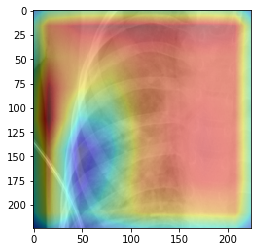

In [0]:

activated_features = SaveFeatures(model._modules.get('densenet121').features.denseblock4.denselayer16)
prediction = model(images)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
topk(pred_probabilities,1)

weight_softmax_params = list(model._modules.get('densenet121').classifier[0].parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
print(weight_softmax.shape)
class_idx = topk(pred_probabilities,1)[1].int()
class_idx

overlay=getCAM(activated_features.features, weight_softmax,class_idx)
from matplotlib.pyplot import imshow
imshow(overlay[0], alpha=0.5, cmap='jet')

import numpy as np
img = images[0].cpu().numpy()[0]
#convert image back to Height,Width,Channels
#img = np.transpose(img, (1,2,0))
print(img.shape)
imshow(img,cmap='gray')
imshow(skimage.transform.resize(overlay[0], images.shape[2:4]), alpha=0.4, cmap='jet');

In [0]:
from torch.nn import functional as F

prediction = model(images)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [0]:
activated_features.features.shape

(1, 1024, 7, 7)

In [0]:
from torch import topk

topk(pred_probabilities,1)

(tensor([0.7311], device='cuda:0'), tensor([1], device='cuda:0'))

In [0]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [0]:
weight_softmax_params = list(model._modules.get('densenet121').classifier[0].parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
print(weight_softmax.shape)
class_idx = topk(pred_probabilities,1)[1].int()
class_idx

(2, 1024)


tensor([1], device='cuda:0', dtype=torch.int32)

In [0]:
print(activated_features.features)

None


In [0]:
overlay=getCAM(activated_features.features, weight_softmax,class_idx)

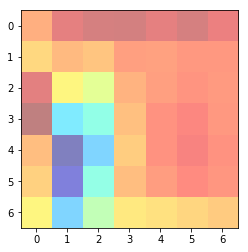

In [0]:
from matplotlib.pyplot import imshow
imshow(overlay[0], alpha=0.5, cmap='jet')

In [0]:
display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [0]:
import numpy as np
img = images.cpu().numpy()[0]
#convert image back to Height,Width,Channels
#img = np.transpose(img, (1,2,0))
print(img.shape)
imshow(img,cmap='gray')


IndexError: ignored

In [0]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


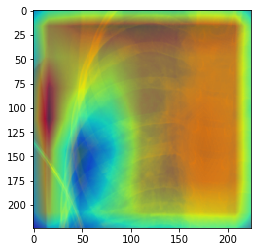

In [0]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform
import numpy as np

imshow(img)
imshow(skimage.transform.resize(overlay[0], images.shape[2:4]), alpha=0.5, cmap='jet');